In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install h5py

In [2]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
mat_import = drive.CreateFile({'id':'16NbTvbchzCrftTP2iVKbmA2a54fQ4nNV'})
mat_import.GetContentFile('project_data.zip') # - 'sample.json' is the file name that will be accessible in the notebook
# print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
# data = sio.loadmat('sample.mat') # load the .mat file.
# R = data['R'][0,:]



    100% |████████████████████████████████| 993kB 19.2MB/s 


In [0]:
import zipfile
with zipfile.ZipFile("project_data.zip","r") as zip_ref:
    zip_ref.extractall()


In [4]:
cd project

/content/project


In [0]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [6]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## preprocessing

In [0]:
def onehotencoding(y_train_valid):
  num_train = y_train_valid.shape[0]
  num_class = len(np.unique(y_train_valid))
  y_train = np.zeros((num_train, num_class))
  y_train[range(num_train), y_train_valid-769] = 1
  return y_train

Y_train = onehotencoding(y_train_valid)
Y_test = onehotencoding(y_test)
Y_test.shape

X_train = X_train_valid[:,0:22,:]
X_test = X_test[:,0:22,:]

In [0]:
# np.unique(person_train_valid)


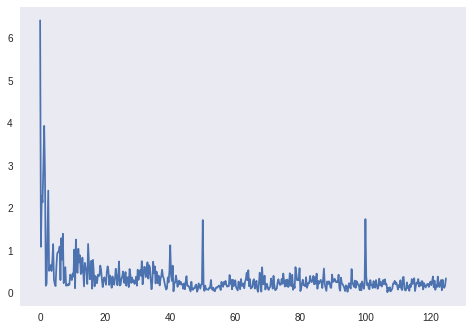

In [0]:
fs = 250
x = np.arange(0,4,1/fs)
y = X_train_valid[28,24,:]
N = len(y)
yf = np.fft.fft(y)
xf = np.arange(0,1/2*fs,fs/N)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [0]:
# pd.DataFrame(X_train)
X_train.shape

(2115, 22, 1000)

## CNN model

### Trail-wise Deep CNN


In [0]:
import keras
from keras.models import Sequential, model_from_json

import keras.backend as K
from keras.layers import Dense, Conv2D,SeparableConv2D, MaxPool2D, AveragePooling2D, Flatten, Activation
from keras.layers import Dropout,SpatialDropout2D, BatchNormalization, LSTM, Reshape
from keras.layers import GRU, GaussianNoise
from keras.callbacks import EarlyStopping


### Without gaussian noise


In [36]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(Dropout(dropout_rate))
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(X_train.reshape(2115,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3199 - acc: 0.2287 - val_loss: 1.4158 - val_acc: 0.3570
Epoch 2/200
1692/1692 [==============================] - 2s 1ms/step - loss: 2.0022 - acc: 0.2902 - val_loss: 1.4808 - val_acc: 0.3593
Epoch 3/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.8305 - acc: 0.3079 - val_loss: 1.4959 - val_acc: 0.3452
Epoch 4/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.6828 - acc: 0.3044 - val_loss: 1.3569 - val_acc: 0.3452
Epoch 5/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.5815 - acc: 0.3144 - val_loss: 1.3813 - val_acc: 0.3712
Epoch 6/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.5173 - acc: 0.3215 - val_loss: 1.3379 - val_acc: 0.3593
Epoch 7/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.4971 - acc: 0.3197 - val_loss: 1.4319 - val_acc: 0.3475
Epoch 8/

443/443 [==============================] - 0s 450us/step
training accu is : 72.16%
val accu is : 52.48%
test accu is : 49.66%


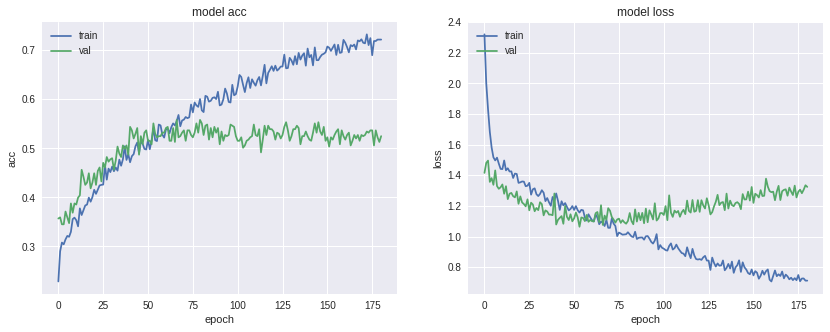

In [37]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### With gaussian noise


In [33]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(Dropout(dropout_rate))
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 991, 25)       275       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 991, 25)       100       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 22, 991, 25)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 991, 25)        13775     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 991, 25)        100       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 991, 25)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 991, 25)        0         
__________

In [0]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history = model.fit(X_train.reshape(2115,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])



443/443 [==============================] - 0s 443us/step
training accu is : 74.17%
val accu is : 51.06%
test accu is : 47.86%


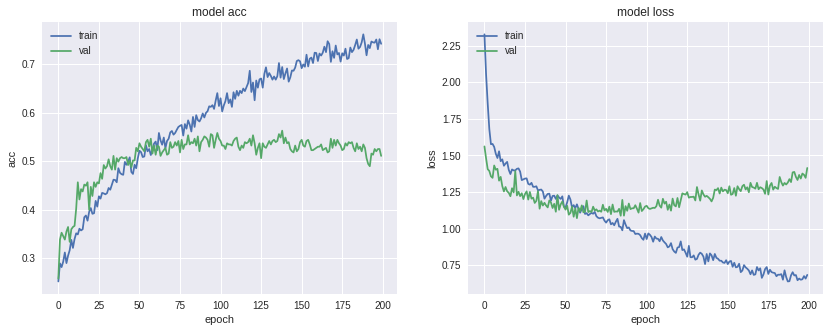

In [35]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### Trail-wise Shallow CNN


#### without noise

In [48]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(1,25), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,40,1)))
model.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
model.add(Flatten())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model.summary()

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff2e832c8d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 2199956768


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 976, 40)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 976, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 976, 40)        160       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 976, 40)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 976, 40, 1)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 61, 40, 1)         0         
__________

In [50]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history = model.fit(X_train.reshape(2115,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.4535 - acc: 0.2707 - val_loss: 1.3316 - val_acc: 0.3641
Epoch 2/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.3315 - acc: 0.3617 - val_loss: 1.3287 - val_acc: 0.3735
Epoch 3/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.2904 - acc: 0.3859 - val_loss: 1.3103 - val_acc: 0.3877
Epoch 4/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.2677 - acc: 0.4226 - val_loss: 1.2759 - val_acc: 0.3853
Epoch 5/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.2292 - acc: 0.4651 - val_loss: 1.2318 - val_acc: 0.4397
Epoch 6/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.1887 - acc: 0.4752 - val_loss: 1.2246 - val_acc: 0.4303
Epoch 7/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.1570 - acc: 0.5059 - val_loss: 1.2054 - val_acc: 0.4563
Epoch 8/

443/443 [==============================] - 0s 1ms/step
training accu is : 77.48%
val accu is : 56.74%
test accu is : 59.59%


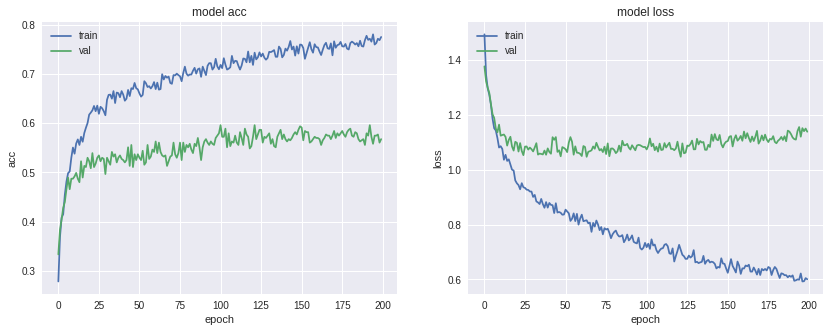

In [40]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [51]:
dropout_rate = 0.6

K.clear_session()
model2 = Sequential()
model2.add(Conv2D(filters=40, kernel_size=(1,25), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
model2.add(BatchNormalization())
model2.add(GaussianNoise(0.1))
model2.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model2.add(BatchNormalization())
model2.add(GaussianNoise(0.1))
model2.add(SpatialDropout2D(dropout_rate))
model2.add(Reshape((-1,40,1)))
model2.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
model2.add(Flatten())
model2.add(Dense(units = 4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 976, 40)       160       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 22, 976, 40)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 976, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 976, 40)        160       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 976, 40)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 976, 40)        0         
__________

In [52]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history2 = model2.fit(X_train.reshape(-1,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 4s 2ms/step - loss: 1.4681 - acc: 0.2937 - val_loss: 1.3651 - val_acc: 0.3404
Epoch 2/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.3544 - acc: 0.3511 - val_loss: 1.3408 - val_acc: 0.3735
Epoch 3/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.2999 - acc: 0.3765 - val_loss: 1.3382 - val_acc: 0.3783
Epoch 4/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.2883 - acc: 0.4019 - val_loss: 1.2868 - val_acc: 0.3948
Epoch 5/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.2371 - acc: 0.4498 - val_loss: 1.2466 - val_acc: 0.4657
Epoch 6/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.1935 - acc: 0.4699 - val_loss: 1.2253 - val_acc: 0.4539
Epoch 7/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.1554 - acc: 0.4846 - val_loss: 1.1600 - val_acc: 0.4894
Epoch 8/

443/443 [==============================] - 0s 729us/step
training accu is : 76.36%
val accu is : 57.68%
test accu is : 57.34%


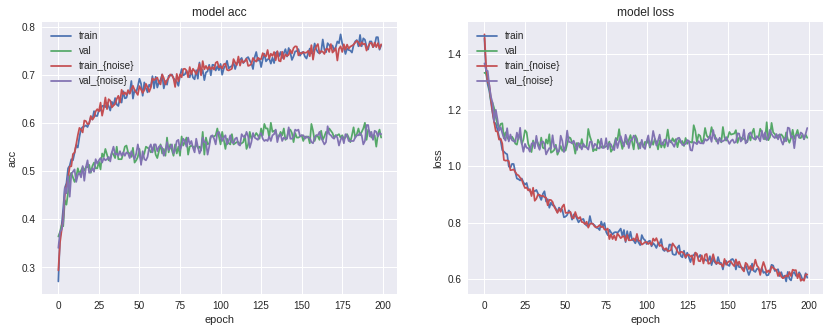

In [54]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history2.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history2.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val','train_{noise}', 'val_{noise}'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val','train_{noise}', 'val_{noise}'], loc='upper left')

plt.show()

### Data argumentation


In [0]:
def dataargment(X_train, Y_train, window, stride, person_idx):
  num_trail, num_eletrode, num_bin = X_train.shape
  num_class = Y_train.shape[1]
  N = (num_bin - window)//stride+1
  X_train_argment = np.empty((num_trail*N, num_eletrode, window))
  Y_train_argment = np.empty((num_trail*N, num_class))
  person_idx_argment = np.empty(num_trail*N)
  for idx_trail in range(num_trail):
    for n in range(N):
      X_train_argment[idx_trail*N+n,:,:] = X_train[idx_trail,:,n*stride:n*stride+window]
      Y_train_argment[idx_trail*N+n] = Y_train[idx_trail]
      person_idx_argment[idx_trail*N+n] = person_idx[idx_trail]
  return X_train_argment, Y_train_argment, person_idx_argment

window = 750
stride = 50
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


## Deep CNN with data argmentation

In [56]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,window,1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))

myadam = keras.optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy',
              optimizer = myadam,
              metrics = ['accuracy'])

# model.summary()

early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

history = model.fit(X_train_argment.reshape(-1,22,window,1), Y_train_argment, 
                    batch_size=256, epochs = 500, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_deep_arg.h5")
print("Saved model to disk")

Train on 10152 samples, validate on 2538 samples
Epoch 1/500
10152/10152 [==============================] - 13s 1ms/step - loss: 2.1335 - acc: 0.2590 - val_loss: 1.6100 - val_acc: 0.2660
Epoch 2/500
10152/10152 [==============================] - 10s 989us/step - loss: 1.5391 - acc: 0.2581 - val_loss: 1.4311 - val_acc: 0.2849
Epoch 3/500
10152/10152 [==============================] - 10s 995us/step - loss: 1.4862 - acc: 0.2580 - val_loss: 1.4331 - val_acc: 0.2388
Epoch 4/500
10152/10152 [==============================] - 10s 989us/step - loss: 1.4735 - acc: 0.2538 - val_loss: 1.4026 - val_acc: 0.2857
Epoch 5/500
10152/10152 [==============================] - 10s 976us/step - loss: 1.4489 - acc: 0.2620 - val_loss: 1.3803 - val_acc: 0.3065
Epoch 6/500
10152/10152 [==============================] - 10s 994us/step - loss: 1.4494 - acc: 0.2656 - val_loss: 1.3879 - val_acc: 0.2530
Epoch 7/500
10152/10152 [==============================] - 10s 993us/step - loss: 1.4559 - acc: 0.2623 - val_loss

2658/2658 [==============================] - 1s 364us/step
best val_accu is : 66.82%
test_accu is : 64.22%


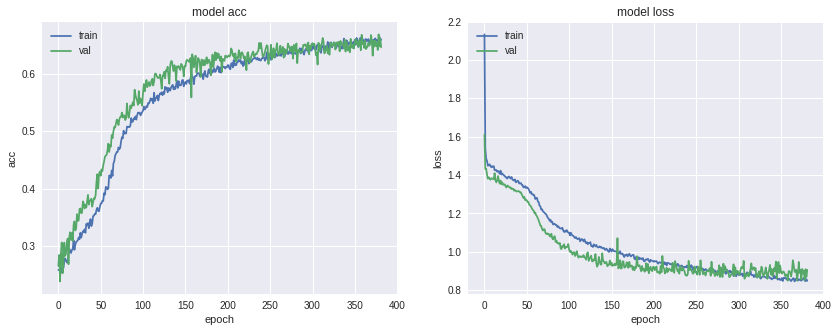

In [58]:
# Majority vote on prediction
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


score, accu = model.evaluate(X_test_argment.reshape(-1,22,window,1), Y_test_argment)
print("best val_accu is : {:2.2%}".format(np.max(history.history['val_acc'])))
print("test_accu is : {:2.2%}".format(accu))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
from google.colab import files

files.download('model_deep_arg.h5')

In [0]:
num_bin = 1000
window = 750
stride = 50
num_test = Y_test.shape[0]
N = (num_bin - window)//stride+1
y_pred = model.predict_classes(X_test_argment.reshape(-1,22,window,1))
y_pred_trialwise = np.zeros(num_test)
for idx_trial in np.arange(num_test):
# for idx_trial in [128]:
  (values,counts) = np.unique(y_pred[idx_trial:idx_trial+N],return_counts=True)
  ind=np.argmax(counts)
  y_pred_trialwise[idx_trial] = values[ind]
  
np.sum(y_pred_trialwise == np.argmax(Y_test)) / num_test

0.40632054176072235

In [0]:
X_test_argment.shape

(2658, 22, 750)

#### Shallow CNN with data argmentation

In [62]:

dropout_rate = 0.6
K.clear_session()
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(1,25), 
                strides=(1, 1), input_shape=(22,window,1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,40,1)))
model.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
model.add(Flatten())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

history = model.fit(X_train_argment.reshape(X_train_argment.shape[0],22,window,1), Y_train_argment, 
                    batch_size=256, epochs = 500, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 0)
print("dropout rate = {} is done.".format(dropout_rate))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_shallow_arg.h5")
print("Saved model to disk")

Epoch 00167: early stopping


NameError: ignored

In [67]:
X_test.shape

(443, 22, 1000)

2658/2658 [==============================] - 1s 499us/step
training accu is : 48.46%
val accu is : 42.12%
test accu is : 41.38%


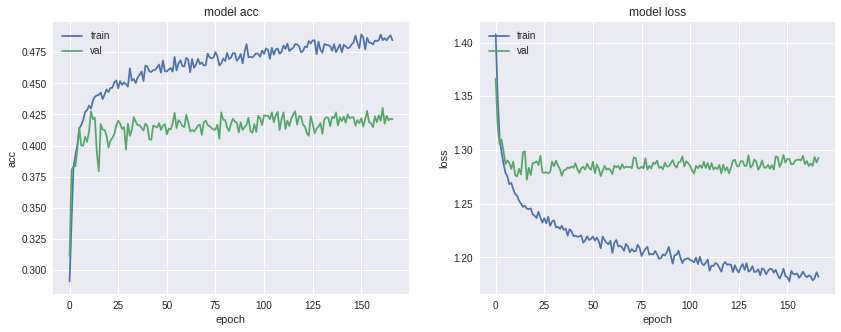

In [69]:
_, accu = model.evaluate(X_test_argment.reshape(-1,22,750,1), Y_test_argment)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
from google.colab import files

files.download('model_shallow_arg.h5')

## Inter subject comparison

In [0]:
def deepcnn(dropout_rate=0.6):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(filters=25, kernel_size=(1,10), 
                  strides=(1, 1), input_shape=(22,window,1),
                  padding ='valid'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate-0.3))
  model.add(Conv2D(filters=25, kernel_size=(22,1), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate-0.3))
  model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
  model.add(Reshape((-1,25,1)))
  model.add(Conv2D(filters=50, kernel_size=(10,25), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,50,1)))
  model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  model.add(Conv2D(filters=100, kernel_size=(10,50), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,100,1)))
  model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  model.add(Conv2D(filters=200, kernel_size=(3,100), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,200,1)))
  model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  model.add(Flatten())
  model.add(Dense(units = 4, activation='softmax'))

  myadam = keras.optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)

  model.compile(loss='categorical_crossentropy',
                optimizer = myadam,
                metrics = ['accuracy'])

  # model.summary()
  return model

def shallowcnn(dropout_rate=0.5):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(filters=40, kernel_size=(1,25), 
                  strides=(1, 1), input_shape=(22,window,1),
                  padding ='valid'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate-0.3))
  model.add(Conv2D(filters=40, kernel_size=(22,1), 
                  strides=(1, 1),
                  padding ='valid'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,40,1)))
  model.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
  model.add(Flatten())
  model.add(Dense(units = 4, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  return model


## intra-subject variability


In [70]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,window,1),
                padding ='valid'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))

myadam = keras.optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy',
              optimizer = myadam,
              metrics = ['accuracy'])

# model.summary()

early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

history = model.fit(X_train_argment.reshape(-1,22,window,1), Y_train_argment, 
                    batch_size=256, epochs = 500, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_deep_arg_wo_bn.h5")
print("Saved model to disk")

Train on 10152 samples, validate on 2538 samples
Epoch 1/500
10152/10152 [==============================] - 6s 597us/step - loss: 1.3953 - acc: 0.2673 - val_loss: 1.3734 - val_acc: 0.3006
Epoch 2/500
10152/10152 [==============================] - 5s 520us/step - loss: 1.3801 - acc: 0.2948 - val_loss: 1.3428 - val_acc: 0.3629
Epoch 3/500
10152/10152 [==============================] - 5s 519us/step - loss: 1.3792 - acc: 0.3031 - val_loss: 1.3386 - val_acc: 0.3542
Epoch 4/500
10152/10152 [==============================] - 5s 518us/step - loss: 1.3709 - acc: 0.3116 - val_loss: 1.3253 - val_acc: 0.3913
Epoch 5/500
10152/10152 [==============================] - 5s 514us/step - loss: 1.3620 - acc: 0.3324 - val_loss: 1.3226 - val_acc: 0.3779
Epoch 6/500
10152/10152 [==============================] - 5s 511us/step - loss: 1.3591 - acc: 0.3320 - val_loss: 1.2942 - val_acc: 0.4086
Epoch 7/500
10152/10152 [==============================] - 5s 515us/step - loss: 1.3449 - acc: 0.3454 - val_loss: 1.2

OSError: ignored

2658/2658 [==============================] - 1s 320us/step
training accu is : 55.01%
val accu is : 62.61%
test accu is : 60.65%


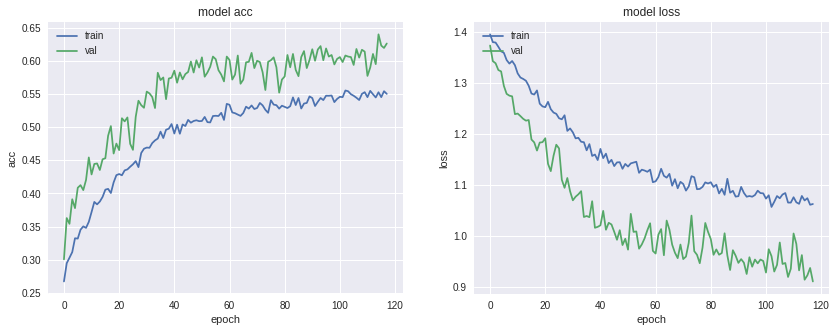

In [73]:
_, accu = model.evaluate(X_test_argment.reshape(-1,22,750,1), Y_test_argment)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### Train deepcnn on single **subject**

In [178]:
num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((num_subject,num_subject))
for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  model_s = deepcnn(0.6)

  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  num_train = X_train_argment[idx_s_train].shape[0]

  history_s = model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  print("Done with one subject")
#   test the accuracy on other subjects
  for num_s_j in np.arange(num_subject):
    idx_s_test = np.where(person_test_idx_argment == num_s_j)[0]
    cross_subject_accu[num_s, num_s_j] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                          Y_test_argment[idx_s_test])[1]




Train on 1137 samples, validate on 285 samples
Epoch 1/200
1137/1137 [==============================] - 2s 2ms/step - loss: 2.7824 - acc: 0.2515 - val_loss: 1.4646 - val_acc: 0.3719
Epoch 2/200
1137/1137 [==============================] - 1s 982us/step - loss: 2.7087 - acc: 0.2682 - val_loss: 1.9572 - val_acc: 0.2982
Epoch 3/200
1137/1137 [==============================] - 1s 995us/step - loss: 2.5169 - acc: 0.2788 - val_loss: 2.2393 - val_acc: 0.2807
Epoch 4/200
1137/1137 [==============================] - 1s 975us/step - loss: 2.3288 - acc: 0.2797 - val_loss: 2.0002 - val_acc: 0.3018
Epoch 5/200
1137/1137 [==============================] - 1s 984us/step - loss: 2.3277 - acc: 0.2559 - val_loss: 2.0973 - val_acc: 0.3018
Epoch 6/200
1137/1137 [==============================] - 1s 980us/step - loss: 2.1592 - acc: 0.2779 - val_loss: 1.9966 - val_acc: 0.3018
Epoch 7/200
1137/1137 [==============================] - 1s 991us/step - loss: 2.1852 - acc: 0.2806 - val_loss: 2.1265 - val_acc: 0.2

In [179]:
cross_subject_accu

array([[0.59      , 0.34333333, 0.48666667, 0.34333333, 0.20212766,
        0.25170068, 0.38333333, 0.36      , 0.32624113],
       [0.30333333, 0.21      , 0.23666667, 0.25      , 0.30496454,
        0.17346939, 0.23666667, 0.26666667, 0.24113475],
       [0.38666667, 0.27666667, 0.46666667, 0.34      , 0.26950355,
        0.28231293, 0.35333333, 0.30666667, 0.30141844],
       [0.27333333, 0.31666667, 0.2       , 0.31666667, 0.33687943,
        0.30272109, 0.26666667, 0.19333333, 0.20567376],
       [0.22      , 0.26666667, 0.33666667, 0.31333333, 0.35460993,
        0.35034014, 0.31666667, 0.23      , 0.35460993],
       [0.23      , 0.29333333, 0.24333333, 0.22333333, 0.25177305,
        0.22789116, 0.33      , 0.35      , 0.32269504],
       [0.27666667, 0.27333333, 0.31      , 0.34333333, 0.39361702,
        0.28231293, 0.44333333, 0.20333333, 0.26595745],
       [0.29666667, 0.24333333, 0.36333333, 0.16333333, 0.33687943,
        0.24829932, 0.22      , 0.43333333, 0.30851064],


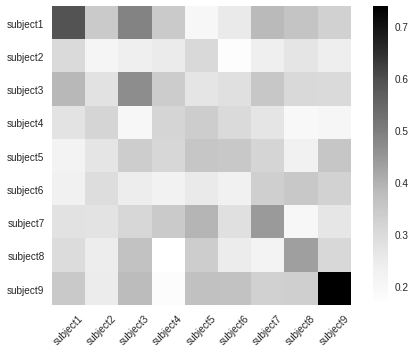

In [180]:
plt.imshow(cross_subject_accu)
plt.grid(False)
subject_id = ['subject1','subject2','subject3','subject4','subject5',
              'subject6','subject7','subject8','subject9']
plt.xticks(range(9), subject_id, rotation='45')
plt.yticks(range(9), subject_id, rotation='0')
plt.colorbar()

# plt.xlabel(subject_id)
# plt.ylabel(subject_id)
# plt.yticks(rotation='vertical')


### Train shallow on single **subject**

In [0]:
num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((num_subject,num_subject))
for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  model_s = shallowcnn(0.6)

  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  num_train = X_train_argment[idx_s_train].shape[0]

  history_s = model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  print("Done with one subject")
#   test the accuracy on other subjects
  for num_s_j in np.arange(num_subject):
    idx_s_test = np.where(person_test_idx_argment == num_s_j)[0]
    cross_subject_accu[num_s, num_s_j] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                          Y_test_argment[idx_s_test])[1]




Train on 1137 samples, validate on 285 samples
Epoch 1/200
1137/1137 [==============================] - 3s 3ms/step - loss: 1.6025 - acc: 0.2586 - val_loss: 1.4088 - val_acc: 0.2737
Epoch 2/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.4642 - acc: 0.2797 - val_loss: 1.3991 - val_acc: 0.2632
Epoch 3/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.4149 - acc: 0.2823 - val_loss: 1.3950 - val_acc: 0.2667
Epoch 4/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.4028 - acc: 0.2885 - val_loss: 1.3828 - val_acc: 0.3123
Epoch 5/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.3725 - acc: 0.3034 - val_loss: 1.3760 - val_acc: 0.3018
Epoch 6/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.3696 - acc: 0.3096 - val_loss: 1.3753 - val_acc: 0.2807
Epoch 7/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.3702 - acc: 0.3210 - val_loss: 1.3730 - val_acc: 0.2877
Epoch 8/

In [0]:
plt.imshow(cross_subject_accu)
plt.grid(False)
subject_id = ['subject1','subject2','subject3','subject4','subject5',
              'subject6','subject7','subject8','subject9']
plt.xticks(range(9), subject_id, rotation='45')
plt.yticks(range(9), subject_id, rotation='0')
plt.colorbar()

# plt.xlabel(subject_id)
# plt.ylabel(subject_id)
# plt.yticks(rotation='vertical')


### Leave one subject out during training

In [0]:
num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((num_subject,num_subject))
for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment != num_s)[0]
  model_s = deepcnn(0.6)
  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  num_train = X_train_argment[idx_s_train].shape[0]

  history_s = model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  print("Done with one subject")
#   test the accuracy on other subjects
  for num_s_j in np.arange(num_subject):
    idx_s_test = np.where(person_test_idx_argment == num_s_j)[0]
    cross_subject_accu[num_s, num_s_j] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                          Y_test_argment[idx_s_test])[1]
plt.imshow(cross_subject_accu)
plt.grid(False)
subject_id = ['subject1','subject2','subject3','subject4','subject5',
              'subject6','subject7','subject8','subject9']
plt.title('Leave one subject out')
plt.xticks(range(9), subject_id, rotation='45')
plt.yticks(range(9), subject_id, rotation='0')
plt.colorbar()



### Fine tune with individaul subject before making prediction.

In [0]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
pretrain_model = model_from_json(loaded_model_json)
# load weights into new model


num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((2,num_subject))

for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  num_train = X_train_argment[idx_s_train].shape[0]

  pretrain_model = model_from_json(loaded_model_json)
  # load weights into new model
  pretrain_model.load_weights("model_deep_arg.h5")
  model_s = pretrain_model
  
  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  
  model_s.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  
  idx_s_test = np.where(person_test_idx_argment == num_s)[0]
  cross_subject_accu[0,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                        Y_test_argment[idx_s_test])[1]

  # fine tune the model
  model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 30, validation_split = 0.2,
                          verbose = 1)

  cross_subject_accu[1,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                        Y_test_argment[idx_s_test])[1]


300/300 [==============================] - 2s 8ms/step
Train on 1137 samples, validate on 285 samples
Epoch 1/30
1137/1137 [==============================] - 4s 4ms/step - loss: 0.6982 - acc: 0.7221 - val_loss: 0.4387 - val_acc: 0.8526
Epoch 2/30
1137/1137 [==============================] - 1s 804us/step - loss: 0.6125 - acc: 0.7643 - val_loss: 0.4278 - val_acc: 0.8842
Epoch 3/30
1137/1137 [==============================] - 1s 815us/step - loss: 0.5841 - acc: 0.7731 - val_loss: 0.4260 - val_acc: 0.8667
Epoch 4/30
1137/1137 [==============================] - 1s 799us/step - loss: 0.5692 - acc: 0.7748 - val_loss: 0.4048 - val_acc: 0.8632
Epoch 5/30
1137/1137 [==============================] - 1s 799us/step - loss: 0.5222 - acc: 0.8012 - val_loss: 0.3966 - val_acc: 0.8561
Epoch 6/30
1137/1137 [==============================] - 1s 793us/step - loss: 0.5438 - acc: 0.7889 - val_loss: 0.3824 - val_acc: 0.8702
Epoch 7/30
1137/1137 [==============================] - 1s 803us/step - loss: 0.5072

Text(0, 0.5, 'Accuracy after fine tuning')

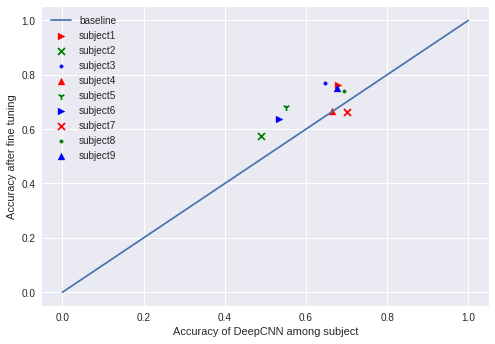

In [0]:
print(cross_subject_accu_30)
subject_id = ['baseline','subject1', 'subject2', 'subject3', 'subject4', 
              'subject5', 'subject6', 'subject7', 'subject8', 'subject9']
plt.plot([0,1],[0,1])
marktypes = ['>','x','.','^','1']
colors = ['r','g','b']
for i in np.arange(num_subject):
  plt.scatter(cross_subject_accu[0,i],cross_subject_accu[1,i], 
              marker=marktypes[i%5], color=colors[i%3])
  plt.legend(subject_id)

plt.xlabel('Accuracy of DeepCNN among subject')
plt.ylabel('Accuracy after fine tuning')

In [0]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
pretrain_model = model_from_json(loaded_model_json)
# load weights into new model


num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu_50 = np.zeros((2,num_subject))

for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  num_train = X_train_argment[idx_s_train].shape[0]

  pretrain_model = model_from_json(loaded_model_json)
  # load weights into new model
  pretrain_model.load_weights("model_deep_arg.h5")
  model_s = pretrain_model
  
  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  
  model_s.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  
  idx_s_test = np.where(person_test_idx_argment == num_s)[0]
  cross_subject_accu_50[0,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                        Y_test_argment[idx_s_test])[1]

  # fine tune the model
  model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 50, validation_split = 0.2,
                          verbose = 1)

  cross_subject_accu_50[1,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                        Y_test_argment[idx_s_test])[1]


300/300 [==============================] - 6s 19ms/step
Train on 1137 samples, validate on 285 samples
Epoch 1/50
1137/1137 [==============================] - 7s 6ms/step - loss: 0.6718 - acc: 0.7361 - val_loss: 0.4333 - val_acc: 0.8702
Epoch 2/50
1137/1137 [==============================] - 1s 793us/step - loss: 0.6022 - acc: 0.7740 - val_loss: 0.4219 - val_acc: 0.8807
Epoch 3/50
1137/1137 [==============================] - 1s 788us/step - loss: 0.5811 - acc: 0.7643 - val_loss: 0.4072 - val_acc: 0.8702
Epoch 4/50
1137/1137 [==============================] - 1s 806us/step - loss: 0.5615 - acc: 0.7748 - val_loss: 0.3928 - val_acc: 0.8772
Epoch 5/50
1137/1137 [==============================] - 1s 793us/step - loss: 0.5431 - acc: 0.7880 - val_loss: 0.3857 - val_acc: 0.8842
Epoch 6/50
1137/1137 [==============================] - 1s 792us/step - loss: 0.5538 - acc: 0.7757 - val_loss: 0.3864 - val_acc: 0.8877
Epoch 7/50
1137/1137 [==============================] - 1s 794us/step - loss: 0.503

Text(0, 0.5, 'Accuracy after fine tuning')

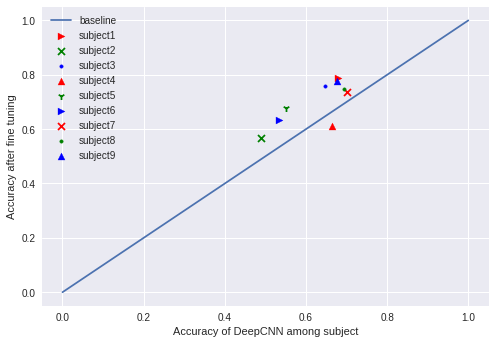

In [0]:
print(cross_subject_accu_50)
subject_id = ['baseline','subject1', 'subject2', 'subject3', 'subject4', 
              'subject5', 'subject6', 'subject7', 'subject8', 'subject9']
plt.plot([0,1],[0,1])
marktypes = ['>','x','.','^','1']
colors = ['r','g','b']
for i in np.arange(num_subject):
  plt.scatter(cross_subject_accu_50[0,i],cross_subject_accu_50[1,i], 
              marker=marktypes[i%5], color=colors[i%3])
  plt.legend(subject_id)

plt.xlabel('Accuracy of DeepCNN among subject')
plt.ylabel('Accuracy after fine tuning')

sample_data/


##RNN model

In [0]:
def vediosegment(X_train, Y_train, window, stride):
  num_trail, num_eletrode, num_bin = X_train.shape
  num_class = Y_train.shape[1]
  N = (num_bin - window)//stride+1
  X_train_argment = np.empty((num_trail, num_eletrode*N, window))
  Y_train_argment = np.empty((num_trail, num_class))
  for idx_trail in range(num_trail):
    for n in range(N):
      X_train_argment[idx_trail*N+n,:,:] = X_train[idx_trail,:,n*stride:n*stride+window]
      Y_train_argment[idx_trail*N+n] = Y_train[idx_trail]
      person_idx_argment[idx_trail*N+n] = person_idx[idx_trail]
  return X_train_argment, Y_train_argment, person_idx_argment

window = 750
stride = 50
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


In [155]:
K.clear_session()

dropout_rate = 0.6
window = 750
K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(25,1), 
                strides=(2, 1), input_shape = (750,22,1),
                padding ='valid'))
model.add(MaxPool2D(pool_size = (5,1)))
model.add(Conv2D(filters=25, kernel_size=(2,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(Reshape((-1,25)))
# model.add(LSTM(64,return_sequences = True, 
#                recurrent_dropout = dropout_rate))
model.add(LSTM(16,return_sequences = True, 
               recurrent_dropout = dropout_rate))
model.add(LSTM(8,return_sequences = False, 
               recurrent_dropout = dropout_rate))
# model.add(LSTM(50, return_sequences = True, 
#                recurrent_dropout = dropout_rate))

# model.add(Reshape((-1,50,1)))
# model.add(Conv2D(filters=50, kernel_size=(25,1), 
#                 strides=(25, 1),
#                 padding ='valid'))

# model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))
# model.add(GaussianNoise(0.5))
# model.add(Conv2D(filters=50, kernel_size=(5,2), 
#                 strides=(1, 1),
#                 padding ='valid'))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))
# model.add(Reshape((-1,25)))

model.add(Dense(4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 363, 22, 25)       650       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 22, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 22, 25)        1275      
_________________________________________________________________
reshape_1 (Reshape)          (None, 1562, 25)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1562, 16)          2688      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
Total para

In [156]:
history = model.fit(X_train_argment.reshape(-1,750,22,1), Y_train_argment, 
                    batch_size=256, epochs = 50, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)


Train on 10152 samples, validate on 2538 samples
Epoch 1/50
10152/10152 [==============================] - 273s 27ms/step - loss: 1.4004 - acc: 0.2443 - val_loss: 1.3897 - val_acc: 0.2565
Epoch 2/50
10152/10152 [==============================] - 270s 27ms/step - loss: 1.3863 - acc: 0.2626 - val_loss: 1.3868 - val_acc: 0.2553
Epoch 3/50
10152/10152 [==============================] - 271s 27ms/step - loss: 1.3845 - acc: 0.2642 - val_loss: 1.3869 - val_acc: 0.2620
Epoch 4/50
10152/10152 [==============================] - 270s 27ms/step - loss: 1.3816 - acc: 0.2757 - val_loss: 1.3874 - val_acc: 0.2510
Epoch 5/50
 9984/10152 [============================>.] - ETA: 4s - loss: 1.3787 - acc: 0.2869 

KeyboardInterrupt: ignored

best val_accu is : 63.99%


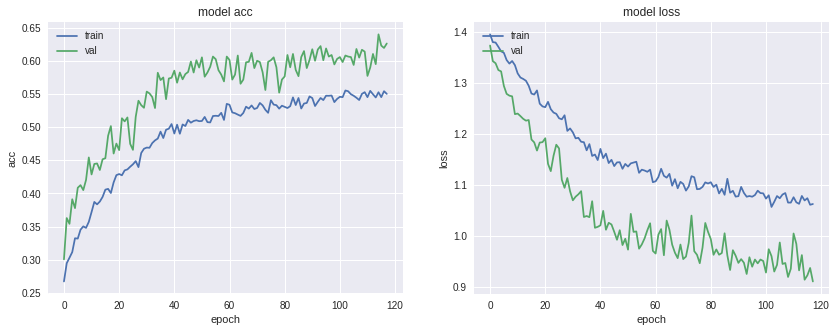

In [99]:
print("best val_accu is : {:2.2%}".format(np.max(history.history['val_acc'])))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [175]:
K.clear_session()

dropout_rate = 0.8
window = 750
K.clear_session()
model = Sequential()
model.add(LSTM(16, input_shape=(750,22),return_sequences = True, 
               recurrent_dropout = dropout_rate,
               dropout = dropout_rate)
         )

model.add(LSTM(16, return_sequences = True, 
              recurrent_dropout = dropout_rate,
               dropout = dropout_rate)
         )

model.add(Reshape((-1,16,1)))
model.add(Conv2D(filters=25, kernel_size=(10,16), 
                strides=(5, 1),
                padding ='valid'))
model.add(Dense(4, activation = 'relu'))
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = ['accuracy'])
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 750, 16)           2496      
_________________________________________________________________
lstm_2 (LSTM)                (None, 750, 16)           2112      
_________________________________________________________________
reshape_1 (Reshape)          (None, 750, 16, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 1, 25)        4025      
_________________________________________________________________
dense_1 (Dense)              (None, 149, 1, 4)         104       
_________________________________________________________________
flatten_1 (Flatten)          (None, 596)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2388      
Total para

In [176]:
history = model.fit(X_train_argment.reshape(-1,750,22), Y_train_argment, 
                    batch_size=256, epochs = 50, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)




Train on 10152 samples, validate on 2538 samples
Epoch 1/50
10152/10152 [==============================] - 142s 14ms/step - loss: 1.3873 - acc: 0.2482 - val_loss: 1.3855 - val_acc: 0.2723
Epoch 2/50
10152/10152 [==============================] - 139s 14ms/step - loss: 1.3877 - acc: 0.2529 - val_loss: 1.3858 - val_acc: 0.2723
Epoch 3/50
10152/10152 [==============================] - 139s 14ms/step - loss: 1.3866 - acc: 0.2529 - val_loss: 1.3859 - val_acc: 0.2565
Epoch 4/50
10152/10152 [==============================] - 139s 14ms/step - loss: 1.3870 - acc: 0.2514 - val_loss: 1.3860 - val_acc: 0.2593
Epoch 5/50
10152/10152 [==============================] - 138s 14ms/step - loss: 1.3862 - acc: 0.2522 - val_loss: 1.3860 - val_acc: 0.2585
Epoch 6/50
10152/10152 [==============================] - 138s 14ms/step - loss: 1.3864 - acc: 0.2505 - val_loss: 1.3859 - val_acc: 0.2600
Epoch 7/50
10152/10152 [==============================] - 137s 14ms/step - loss: 1.3858 - acc: 0.2572 - val_loss: 1.3

## Using frequency doamin

In [0]:
def dataargment(X_train, Y_train, window, stride, person_idx):
  num_trail, num_eletrode, num_bin = X_train.shape
  num_class = Y_train.shape[1]
  N = (num_bin - window)//stride+1
  X_train_argment = np.empty((num_trail*N, num_eletrode, window))
  Y_train_argment = np.empty((num_trail*N, num_class))
  person_idx_argment = np.empty(num_trail*N)
  for idx_trail in range(num_trail):
    for n in range(N):
      X_train_argment[idx_trail*N+n,:,:] = X_train[idx_trail,:,n*stride:n*stride+window]
      Y_train_argment[idx_trail*N+n] = Y_train[idx_trail]
      person_idx_argment[idx_trail*N+n] = person_idx[idx_trail]
  return X_train_argment, Y_train_argment, person_idx_argment

window = 200
stride = 200
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)


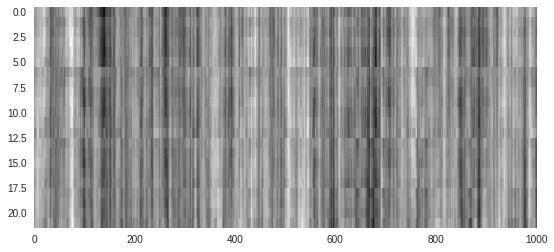

In [0]:
plt.figure(figsize = (9,8))
plt.imshow(X_train[18,:], cmap = 'gray',aspect = 20)
plt.grid(False)

In [0]:
def findpowerspectrum(X):
  N = X[0,0:200].shape[1]
  X_spectrum = 2.0/N * np.abs(np.fft.fft(X))
  return X_spectrum[:,:,0:N//2]
X_spectrum = findpowerspectrum(X_train)

(22, 500)

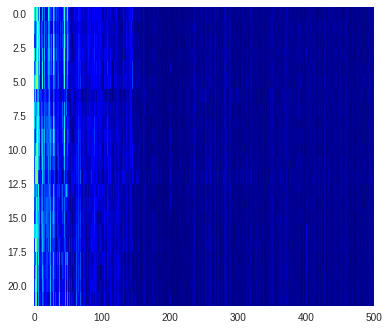

In [16]:
plt.imshow(X_spectrum[55,:],cmap='jet',aspect = 20)
plt.grid(False)
X_spectrum[18,:].shape

In [74]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(1,3), 
                strides=(1, 1), input_shape=(22,500,1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Reshape((-1,40,1)))
model.add(AveragePooling2D(pool_size=(15,1), strides = (5,1)))
model.add(Flatten())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'RMSprop',
              metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 498, 40)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 498, 40)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 498, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 498, 40)        160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 498, 40)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 498, 40, 1)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 97, 40, 1)         0         
__________

In [0]:
history = model.fit(X_spectrum.reshape(2115,22,500,1), Y_train, 
                    batch_size=256, epochs = 100, validation_split = 0.1,
                    callbacks = [early_stop])
# history = model.fit(X_spectrum.reshape(2115,22,500,1), Y_train, 
#                     batch_size=256, epochs = 1000, validation_split = 0.1)


Train on 1903 samples, validate on 212 samples
Epoch 1/100
1903/1903 [==============================] - 2s 814us/step - loss: 1.2220 - acc: 0.4577 - val_loss: 1.3782 - val_acc: 0.3821
Epoch 2/100
1903/1903 [==============================] - 1s 763us/step - loss: 1.0786 - acc: 0.5439 - val_loss: 1.4318 - val_acc: 0.3443
Epoch 3/100
1903/1903 [==============================] - 1s 758us/step - loss: 1.0990 - acc: 0.5281 - val_loss: 1.3317 - val_acc: 0.4009
Epoch 4/100
1903/1903 [==============================] - 1s 764us/step - loss: 1.0844 - acc: 0.5365 - val_loss: 1.4094 - val_acc: 0.3396
Epoch 5/100
1903/1903 [==============================] - 1s 760us/step - loss: 1.0798 - acc: 0.5397 - val_loss: 1.4566 - val_acc: 0.3255
Epoch 6/100
1903/1903 [==============================] - 1s 761us/step - loss: 1.1622 - acc: 0.4882 - val_loss: 1.3854 - val_acc: 0.3821
Epoch 7/100
1903/1903 [==============================] - 1s 756us/step - loss: 1.0909 - acc: 0.5292 - val_loss: 1.3782 - val_acc: 0

In [0]:
X_spectrum.shape

(2115, 25, 500)